In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import sys
import pmdarima as pm

In [2]:
#note: it was pretty difficult finding a time series that did not have seasonailty so I used an ARIMA model on
#a dataset that would have most likely been better forecasted using a SARIMA model 
#load dataset
df = pd.read_csv("AirPassengers.csv")

 
print(df)

       Month  #Passengers
0    1949-01          112
1    1949-02          118
2    1949-03          132
3    1949-04          129
4    1949-05          121
..       ...          ...
139  1960-08          606
140  1960-09          508
141  1960-10          461
142  1960-11          390
143  1960-12          432

[144 rows x 2 columns]


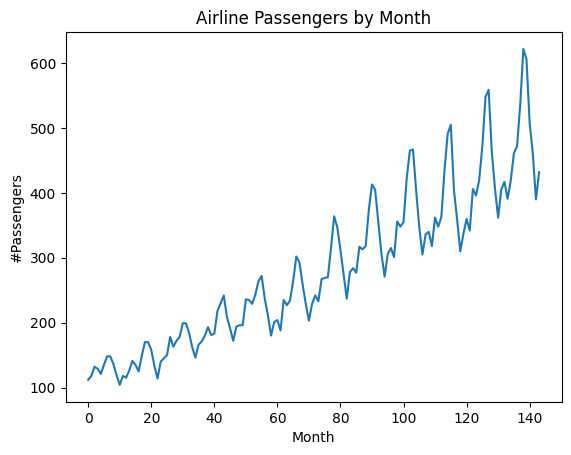

In [3]:
#plot dataset
plt.plot(df.index, df["#Passengers"])
plt.xlabel("Month")
plt.ylabel("#Passengers")
plt.title("Airline Passengers by Month")
plt.draw()
plt.show()

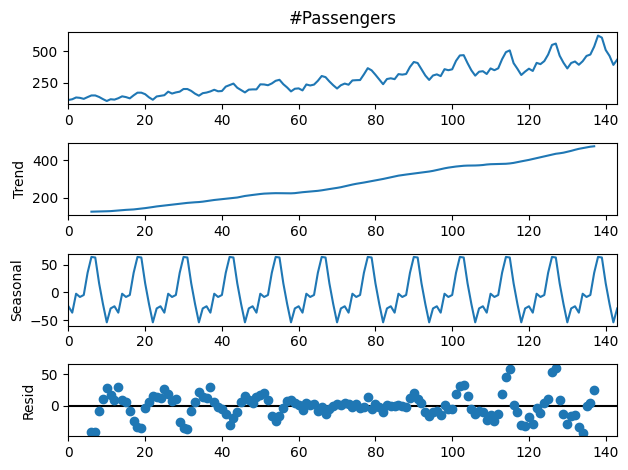

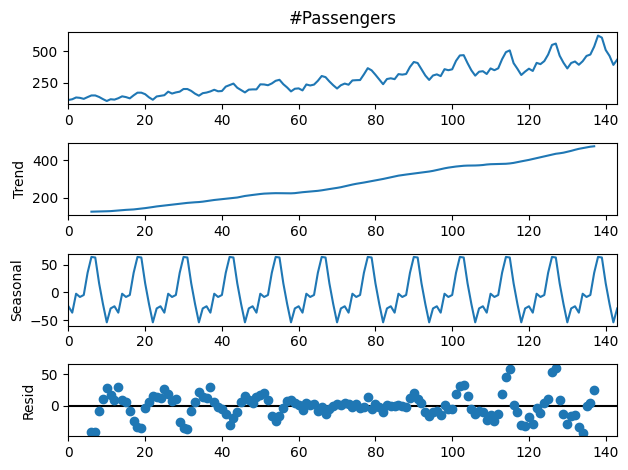

In [4]:
#decompose the time series to observe any trend or seasonality 
seasonal_decompose(df["#Passengers"], period=12).plot()

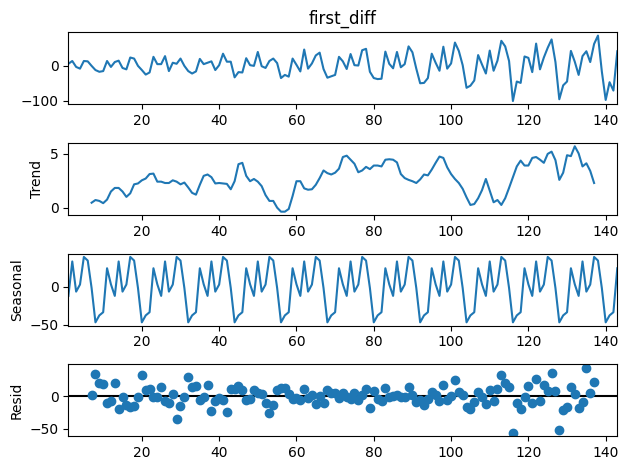

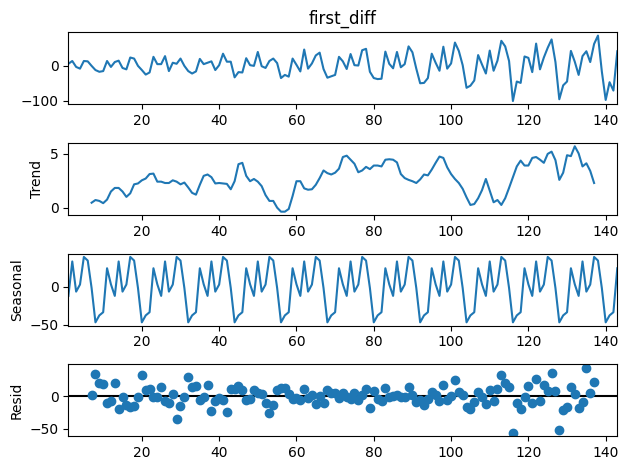

In [5]:
#There are obvious trend and seasonality componenets to the dataset 
#test to see if differencing the dataset visibilly removes any trend component 

df["first_diff"] = df["#Passengers"].diff()

seasonal_decompose(df["first_diff"].dropna(), period=12).plot()

In [6]:
#use dickey-fuller test to check for seasonality in non differneced data
result = adfuller(df["first_diff"].dropna())
print(f"p-value: {result[1]}")

p-value: 0.05421329028382508


p-value: 2.732891850014516e-29


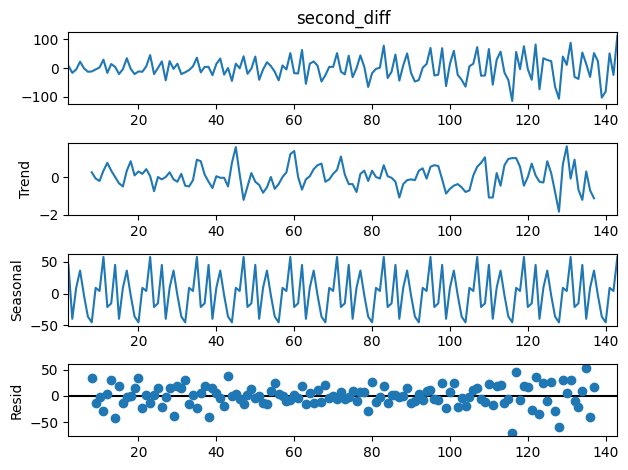

In [7]:
#our p value is on the threshold needed to reject our null hypothesis, I will try second differencing to see what impact is made

df["second_diff"] = df["first_diff"].diff()

seasonal_decompose(df["second_diff"].dropna(), period=12).plot()

result = adfuller(df["second_diff"].dropna())
print(f"p-value: {result[1]}")

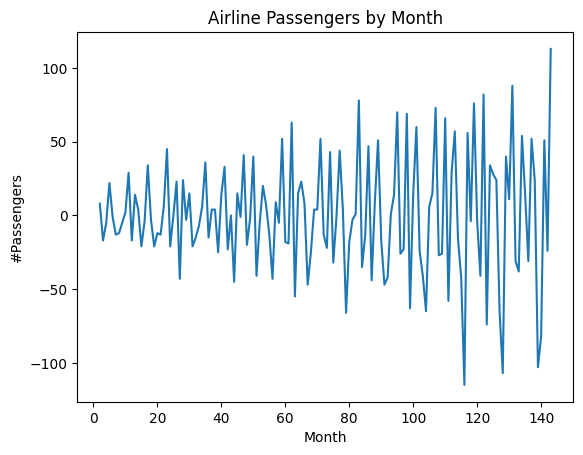

/home/evan/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


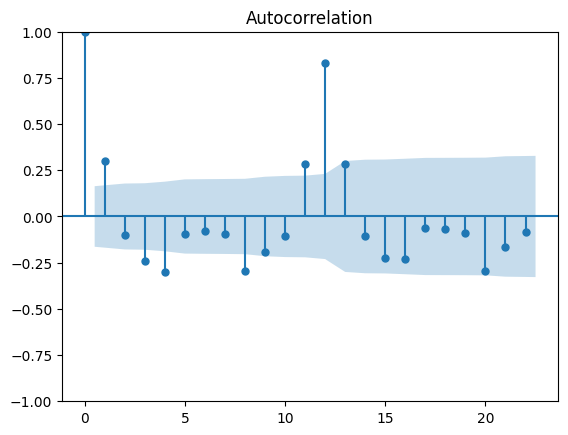

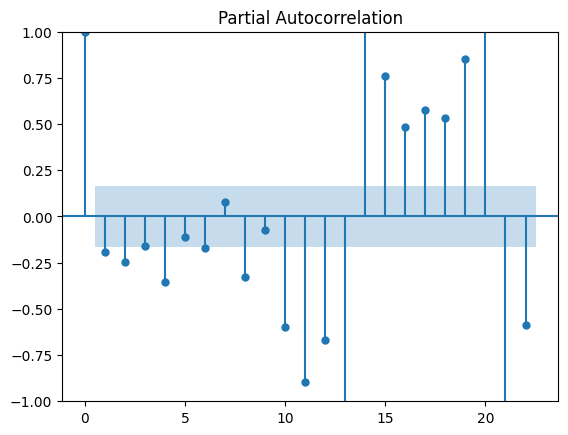

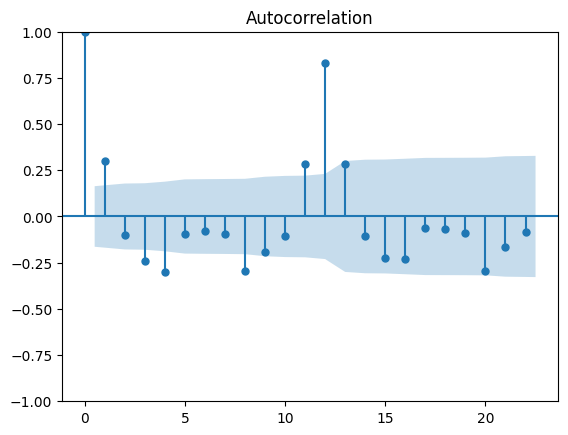

In [8]:
#Our time series is now stationary, now we can estimate our paremeters for the ARIMA model
plt.plot(df.index, df["second_diff"])
plt.xlabel("Month")
plt.ylabel("#Passengers")
plt.title("Airline Passengers by Month")
plt.draw()
plt.show()

plot_pacf(df["second_diff"].dropna())
plot_acf(df["first_diff"].dropna())

In [11]:
#our ACF tells us there are two significant lags to add to our model. PACF tells us to use a higher number of lags, we will automate this process using AIC cost function
#I will fit the model with a high number of p values since the data highly predictable based on past lags
#"""
diff = 1
best_aic = sys.float_info.max
best_p = 0
best_q = 0


for p in range(15):
    for q in range(5):
        try:
            arima = ARIMA(endog = df["#Passengers"].dropna(), order=(p, diff, q))
        
            model = arima.fit()
        
            print({f"Model for ARIMA {p} {diff} {q}"})
            print(model.summary())
            if model.aic < best_aic:
                best_aic = model.aic
                best_p = p
                best_q = q
        except:
            pass

print(f"p: {best_p}")
print(f"q: {best_q}")

{'Model for ARIMA 0 1 0'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -705.955
Date:                Sun, 29 Jan 2023   AIC                           1413.909
Time:                        08:59:01   BIC                           1416.872
Sample:                             0   HQIC                          1415.113
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1136.4015    119.157      9.537      0.000     902.858    1369.945
Ljung-Box (L1) (Q):                  13.39   Jarque-Bera (JB):                 4.99
Prob(Q):             

/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Model for ARIMA 0 1 4'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(0, 1, 4)   Log Likelihood                -680.925
Date:                Sun, 29 Jan 2023   AIC                           1371.850
Time:                        08:59:01   BIC                           1386.664
Sample:                             0   HQIC                          1377.870
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3187      0.073      4.386      0.000       0.176       0.461
ma.L2         -0.2120      0.081     -2.606      0.009      -0.371      -0.053
ma.L3         -0.2313     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model for ARIMA 0 1 7'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(0, 1, 7)   Log Likelihood                -664.579
Date:                Sun, 29 Jan 2023   AIC                           1345.159
Time:                        08:59:04   BIC                           1368.862
Sample:                             0   HQIC                          1354.791
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0170     29.203      0.001      1.000     -57.219      57.253
ma.L2         -0.4526     28.526     -0.016      0.987     -56.362      55.457
ma.L3         -0.3368     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model for ARIMA 0 1 9'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(0, 1, 9)   Log Likelihood                -655.092
Date:                Sun, 29 Jan 2023   AIC                           1330.183
Time:                        08:59:06   BIC                           1359.812
Sample:                             0   HQIC                          1342.223
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3285    201.511      0.002      0.999    -394.626     395.283
ma.L2          0.1563    114.180      0.001      0.999    -223.633     223.946
ma.L3         -0.3676    2

/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Model for ARIMA 1 1 4'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(1, 1, 4)   Log Likelihood                -680.894
Date:                Sun, 29 Jan 2023   AIC                           1373.789
Time:                        08:59:07   BIC                           1391.566
Sample:                             0   HQIC                          1381.013
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0431      0.182     -0.237      0.812      -0.399       0.313
ma.L1          0.3525      0.138      2.554      0.011       0.082       0.623
ma.L2         -0.1918     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Model for ARIMA 1 1 5'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(1, 1, 5)   Log Likelihood                -669.816
Date:                Sun, 29 Jan 2023   AIC                           1353.633
Time:                        08:59:08   BIC                           1374.372
Sample:                             0   HQIC                          1362.060
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6976      0.085      8.181      0.000       0.530       0.865
ma.L1         -0.6031     12.553     -0.048      0.962     -25.207      24.001
ma.L2         -0.2815     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model for ARIMA 1 1 6'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(1, 1, 6)   Log Likelihood                -668.835
Date:                Sun, 29 Jan 2023   AIC                           1353.670
Time:                        08:59:09   BIC                           1377.373
Sample:                             0   HQIC                          1363.302
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5256      0.133      3.954      0.000       0.265       0.786
ma.L1         -0.3243      3.529     -0.092      0.927      -7.242       6.593
ma.L2         -0.4213     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model for ARIMA 1 1 8'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(1, 1, 8)   Log Likelihood                -658.818
Date:                Sun, 29 Jan 2023   AIC                           1337.636
Time:                        08:59:11   BIC                           1367.265
Sample:                             0   HQIC                          1349.676
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1192      0.277     -0.430      0.667      -0.663       0.424
ma.L1          0.3032     12.989      0.023      0.981     -25.155      25.762
ma.L2         -0.5014     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model for ARIMA 1 1 9'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(1, 1, 9)   Log Likelihood                -657.835
Date:                Sun, 29 Jan 2023   AIC                           1337.669
Time:                        08:59:13   BIC                           1370.260
Sample:                             0   HQIC                          1350.913
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5213      0.099      5.278      0.000       0.328       0.715
ma.L1         -0.4091    186.659     -0.002      0.998    -366.255     365.437
ma.L2         -0.5180    2

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Model for ARIMA 2 1 2'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -671.673
Date:                Sun, 29 Jan 2023   AIC                           1353.347
Time:                        08:59:13   BIC                           1368.161
Sample:                             0   HQIC                          1359.366
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6850      0.020     83.060      0.000       1.645       1.725
ar.L2         -0.9548      0.017    -55.420      0.000      -0.989      -0.921
ma.L1         -1.8432     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Model for ARIMA 2 1 4'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(2, 1, 4)   Log Likelihood                -674.189
Date:                Sun, 29 Jan 2023   AIC                           1362.377
Time:                        08:59:14   BIC                           1383.117
Sample:                             0   HQIC                          1370.805
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1333      0.088     -1.507      0.132      -0.307       0.040
ar.L2         -0.3594      0.087     -4.136      0.000      -0.530      -0.189
ma.L1          0.4543     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model for ARIMA 2 1 6'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(2, 1, 6)   Log Likelihood                -666.895
Date:                Sun, 29 Jan 2023   AIC                           1351.790
Time:                        08:59:16   BIC                           1378.455
Sample:                             0   HQIC                          1362.625
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0767      0.181      0.423      0.672      -0.278       0.432
ar.L2          0.3243      0.164      1.982      0.048       0.004       0.645
ma.L1          0.1400     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model for ARIMA 2 1 7'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(2, 1, 7)   Log Likelihood                -661.998
Date:                Sun, 29 Jan 2023   AIC                           1343.995
Time:                        08:59:17   BIC                           1373.624
Sample:                             0   HQIC                          1356.035
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8221      0.122      6.715      0.000       0.582       1.062
ar.L2         -0.3499      0.129     -2.719      0.007      -0.602      -0.098
ma.L1         -0.7403     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model for ARIMA 2 1 8'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(2, 1, 8)   Log Likelihood                -652.524
Date:                Sun, 29 Jan 2023   AIC                           1327.049
Time:                        08:59:19   BIC                           1359.640
Sample:                             0   HQIC                          1340.292
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4190      0.117      3.574      0.000       0.189       0.649
ar.L2         -0.4007      0.121     -3.309      0.001      -0.638      -0.163
ma.L1         -0.3253     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model for ARIMA 2 1 9'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(2, 1, 9)   Log Likelihood                -645.680
Date:                Sun, 29 Jan 2023   AIC                           1315.359
Time:                        08:59:21   BIC                           1350.914
Sample:                             0   HQIC                          1329.807
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1224      0.094     -1.298      0.194      -0.307       0.062
ar.L2         -0.4555      0.096     -4.742      0.000      -0.644      -0.267
ma.L1          0.2680   1.

/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/evan/.local/

{'Model for ARIMA 3 1 3'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -665.969
Date:                Sun, 29 Jan 2023   AIC                           1345.938
Time:                        08:59:21   BIC                           1366.678
Sample:                             0   HQIC                          1354.366
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0097      0.158      6.370      0.000       0.699       1.320
ar.L2          0.1663      0.255      0.652      0.515      -0.334       0.666
ar.L3         -0.6231     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Model for ARIMA 3 1 4'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(3, 1, 4)   Log Likelihood                -667.440
Date:                Sun, 29 Jan 2023   AIC                           1350.880
Time:                        08:59:22   BIC                           1374.583
Sample:                             0   HQIC                          1360.512
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7156      0.124      5.759      0.000       0.472       0.959
ar.L2          0.5852      0.167      3.504      0.000       0.258       0.912
ar.L3         -0.7694     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model for ARIMA 3 1 5'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(3, 1, 5)   Log Likelihood                -673.092
Date:                Sun, 29 Jan 2023   AIC                           1364.184
Time:                        08:59:23   BIC                           1390.850
Sample:                             0   HQIC                          1375.020
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0231      1.013      0.023      0.982      -1.962       2.008
ar.L2         -0.3459      0.167     -2.075      0.038      -0.673      -0.019
ar.L3          0.1724     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model for ARIMA 3 1 6'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(3, 1, 6)   Log Likelihood                -668.735
Date:                Sun, 29 Jan 2023   AIC                           1357.470
Time:                        08:59:25   BIC                           1387.098
Sample:                             0   HQIC                          1369.509
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0062      0.131      7.662      0.000       0.749       1.264
ar.L2         -0.6077      0.110     -5.515      0.000      -0.824      -0.392
ar.L3          0.0552     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model for ARIMA 3 1 8'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(3, 1, 8)   Log Likelihood                -660.159
Date:                Sun, 29 Jan 2023   AIC                           1344.317
Time:                        08:59:28   BIC                           1379.871
Sample:                             0   HQIC                          1358.765
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8607      0.574      1.499      0.134      -0.265       1.986
ar.L2         -0.0777      0.257     -0.303      0.762      -0.581       0.425
ar.L3         -0.1389     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model for ARIMA 3 1 9'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(3, 1, 9)   Log Likelihood                -644.568
Date:                Sun, 29 Jan 2023   AIC                           1315.137
Time:                        08:59:30   BIC                           1353.654
Sample:                             0   HQIC                          1330.788
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0753      0.123     -0.613      0.540      -0.316       0.166
ar.L2         -0.4517      0.094     -4.782      0.000      -0.637      -0.267
ar.L3          0.1092     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Model for ARIMA 4 1 3'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(4, 1, 3)   Log Likelihood                -674.913
Date:                Sun, 29 Jan 2023   AIC                           1365.825
Time:                        08:59:31   BIC                           1389.528
Sample:                             0   HQIC                          1375.457
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5582      0.117     -4.782      0.000      -0.787      -0.329
ar.L2          0.4935      0.113      4.375      0.000       0.272       0.715
ar.L3          0.1238     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Model for ARIMA 4 1 4'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -662.193
Date:                Sun, 29 Jan 2023   AIC                           1342.387
Time:                        08:59:32   BIC                           1369.053
Sample:                             0   HQIC                          1353.223
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0345      0.063     -0.552      0.581      -0.157       0.088
ar.L2          1.0225      0.056     18.127      0.000       0.912       1.133
ar.L3         -0.0676     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model for ARIMA 4 1 5'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(4, 1, 5)   Log Likelihood                -659.704
Date:                Sun, 29 Jan 2023   AIC                           1339.408
Time:                        08:59:33   BIC                           1369.036
Sample:                             0   HQIC                          1351.447
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7905      0.105      7.551      0.000       0.585       0.996
ar.L2         -0.3858      0.144     -2.681      0.007      -0.668      -0.104
ar.L3          0.5194     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model for ARIMA 4 1 6'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(4, 1, 6)   Log Likelihood                -654.983
Date:                Sun, 29 Jan 2023   AIC                           1331.967
Time:                        08:59:35   BIC                           1364.558
Sample:                             0   HQIC                          1345.210
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4319      0.080     17.852      0.000       1.275       1.589
ar.L2         -1.0704      0.139     -7.674      0.000      -1.344      -0.797
ar.L3          0.7094     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model for ARIMA 4 1 7'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(4, 1, 7)   Log Likelihood                -656.579
Date:                Sun, 29 Jan 2023   AIC                           1337.158
Time:                        08:59:37   BIC                           1372.712
Sample:                             0   HQIC                          1351.605
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3778      0.127      2.980      0.003       0.129       0.626
ar.L2          0.0460      0.122      0.378      0.705      -0.193       0.285
ar.L3         -0.0909     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model for ARIMA 4 1 8'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(4, 1, 8)   Log Likelihood                -649.651
Date:                Sun, 29 Jan 2023   AIC                           1325.303
Time:                        08:59:39   BIC                           1363.820
Sample:                             0   HQIC                          1340.954
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4200      0.116      3.621      0.000       0.193       0.647
ar.L2         -0.5854      0.149     -3.942      0.000      -0.876      -0.294
ar.L3         -0.4018     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model for ARIMA 4 1 9'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(4, 1, 9)   Log Likelihood                -626.172
Date:                Sun, 29 Jan 2023   AIC                           1280.343
Time:                        08:59:42   BIC                           1321.823
Sample:                             0   HQIC                          1297.199
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7078      0.032     22.067      0.000       0.645       0.771
ar.L2         -0.2085      0.055     -3.792      0.000      -0.316      -0.101
ar.L3          0.6873     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Model for ARIMA 5 1 3'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(5, 1, 3)   Log Likelihood                -674.675
Date:                Sun, 29 Jan 2023   AIC                           1367.349
Time:                        08:59:44   BIC                           1394.015
Sample:                             0   HQIC                          1378.185
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6566      0.107     -6.118      0.000      -0.867      -0.446
ar.L2          0.5069      0.116      4.363      0.000       0.279       0.735
ar.L3          0.1612     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Model for ARIMA 5 1 4'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(5, 1, 4)   Log Likelihood                -673.541
Date:                Sun, 29 Jan 2023   AIC                           1367.082
Time:                        08:59:45   BIC                           1396.710
Sample:                             0   HQIC                          1379.121
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2248      0.083      2.708      0.007       0.062       0.388
ar.L2          1.4041      0.083     16.874      0.000       1.241       1.567
ar.L3         -0.6108     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model for ARIMA 5 1 5'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -656.559
Date:                Sun, 29 Jan 2023   AIC                           1335.119
Time:                        08:59:47   BIC                           1367.710
Sample:                             0   HQIC                          1348.362
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5353      0.207      2.584      0.010       0.129       0.941
ar.L2         -0.1091      0.185     -0.589      0.556      -0.472       0.254
ar.L3          0.4098     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model for ARIMA 5 1 6'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(5, 1, 6)   Log Likelihood                -651.669
Date:                Sun, 29 Jan 2023   AIC                           1327.339
Time:                        08:59:48   BIC                           1362.893
Sample:                             0   HQIC                          1341.786
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2335      0.156      7.888      0.000       0.927       1.540
ar.L2         -0.7968      0.229     -3.475      0.001      -1.246      -0.347
ar.L3          0.3546     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model for ARIMA 5 1 7'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(5, 1, 7)   Log Likelihood                -651.872
Date:                Sun, 29 Jan 2023   AIC                           1329.743
Time:                        08:59:50   BIC                           1368.260
Sample:                             0   HQIC                          1345.395
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4431      0.107      4.134      0.000       0.233       0.653
ar.L2          0.0535      0.133      0.401      0.688      -0.208       0.315
ar.L3         -0.1015     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model for ARIMA 5 1 8'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(5, 1, 8)   Log Likelihood                -645.089
Date:                Sun, 29 Jan 2023   AIC                           1318.177
Time:                        08:59:52   BIC                           1359.657
Sample:                             0   HQIC                          1335.032
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6221      0.118      5.260      0.000       0.390       0.854
ar.L2         -0.5379      0.163     -3.297      0.001      -0.858      -0.218
ar.L3         -0.1313     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model for ARIMA 5 1 9'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(5, 1, 9)   Log Likelihood                -632.428
Date:                Sun, 29 Jan 2023   AIC                           1294.856
Time:                        08:59:55   BIC                           1339.298
Sample:                             0   HQIC                          1312.915
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4353      0.127      3.439      0.001       0.187       0.683
ar.L2         -0.0357      0.096     -0.371      0.711      -0.225       0.153
ar.L3          0.6400     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Model for ARIMA 6 1 3'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(6, 1, 3)   Log Likelihood                -651.156
Date:                Sun, 29 Jan 2023   AIC                           1322.312
Time:                        08:59:58   BIC                           1351.940
Sample:                             0   HQIC                          1334.351
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0373      0.170      6.105      0.000       0.704       1.370
ar.L2         -0.2657      0.265     -1.002      0.317      -0.786       0.254
ar.L3         -0.3570     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Model for ARIMA 6 1 4'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(6, 1, 4)   Log Likelihood                -651.055
Date:                Sun, 29 Jan 2023   AIC                           1324.110
Time:                        08:59:59   BIC                           1356.701
Sample:                             0   HQIC                          1337.354
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2405      0.126      1.909      0.056      -0.006       0.488
ar.L2          0.5206      0.114      4.557      0.000       0.297       0.744
ar.L3         -0.2422     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model for ARIMA 6 1 5'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(6, 1, 5)   Log Likelihood                -654.721
Date:                Sun, 29 Jan 2023   AIC                           1333.442
Time:                        08:59:59   BIC                           1368.996
Sample:                             0   HQIC                          1347.889
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6525      0.179      3.650      0.000       0.302       1.003
ar.L2         -0.3583      0.230     -1.557      0.120      -0.810       0.093
ar.L3          0.4702     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model for ARIMA 6 1 6'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(6, 1, 6)   Log Likelihood                -642.236
Date:                Sun, 29 Jan 2023   AIC                           1310.472
Time:                        09:00:00   BIC                           1348.989
Sample:                             0   HQIC                          1326.123
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.2811      0.159     14.353      0.000       1.970       2.593
ar.L2         -3.2287      0.358     -9.018      0.000      -3.930      -2.527
ar.L3          3.0468     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model for ARIMA 6 1 7'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(6, 1, 7)   Log Likelihood                -648.226
Date:                Sun, 29 Jan 2023   AIC                           1324.452
Time:                        09:00:03   BIC                           1365.932
Sample:                             0   HQIC                          1341.307
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7662      0.095      8.051      0.000       0.580       0.953
ar.L2          0.1947      0.074      2.626      0.009       0.049       0.340
ar.L3         -0.7510     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model for ARIMA 6 1 8'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(6, 1, 8)   Log Likelihood                -645.036
Date:                Sun, 29 Jan 2023   AIC                           1320.072
Time:                        09:00:05   BIC                           1364.515
Sample:                             0   HQIC                          1338.132
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7320      0.171     10.146      0.000       1.397       2.067
ar.L2         -1.9818      0.407     -4.875      0.000      -2.779      -1.185
ar.L3          1.6467     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model for ARIMA 6 1 9'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(6, 1, 9)   Log Likelihood                -624.110
Date:                Sun, 29 Jan 2023   AIC                           1280.219
Time:                        09:00:08   BIC                           1327.625
Sample:                             0   HQIC                          1299.483
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7103      0.140      5.060      0.000       0.435       0.985
ar.L2         -0.2310      0.153     -1.511      0.131      -0.531       0.069
ar.L3          0.6764     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/evan/.local/lib/pytho

{'Model for ARIMA 7 1 4'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(7, 1, 4)   Log Likelihood                -640.253
Date:                Sun, 29 Jan 2023   AIC                           1304.506
Time:                        09:00:12   BIC                           1340.060
Sample:                             0   HQIC                          1318.953
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7534      0.539      1.398      0.162      -0.303       1.810
ar.L2          0.1183      0.875      0.135      0.893      -1.597       1.834
ar.L3         -0.9216     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model for ARIMA 7 1 5'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(7, 1, 5)   Log Likelihood                -647.803
Date:                Sun, 29 Jan 2023   AIC                           1321.606
Time:                        09:00:13   BIC                           1360.123
Sample:                             0   HQIC                          1337.257
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2203      0.216      1.019      0.308      -0.203       0.644
ar.L2         -0.0742      0.216     -0.343      0.732      -0.498       0.350
ar.L3         -0.0138     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model for ARIMA 7 1 6'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(7, 1, 6)   Log Likelihood                -643.185
Date:                Sun, 29 Jan 2023   AIC                           1314.370
Time:                        09:00:15   BIC                           1355.849
Sample:                             0   HQIC                          1331.225
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4309      0.167      2.581      0.010       0.104       0.758
ar.L2         -0.1063      0.196     -0.541      0.588      -0.491       0.279
ar.L3          0.0159     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model for ARIMA 7 1 7'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(7, 1, 7)   Log Likelihood                -642.804
Date:                Sun, 29 Jan 2023   AIC                           1315.608
Time:                        09:00:18   BIC                           1360.051
Sample:                             0   HQIC                          1333.667
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6967      0.119      5.864      0.000       0.464       0.930
ar.L2         -0.0563      0.167     -0.337      0.736      -0.384       0.271
ar.L3         -0.4428     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model for ARIMA 7 1 8'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(7, 1, 8)   Log Likelihood                -624.772
Date:                Sun, 29 Jan 2023   AIC                           1281.544
Time:                        09:00:21   BIC                           1328.950
Sample:                             0   HQIC                          1300.808
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7491      0.151      4.973      0.000       0.454       1.044
ar.L2         -0.1691      0.246     -0.688      0.491      -0.650       0.312
ar.L3         -0.3746     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model for ARIMA 7 1 9'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(7, 1, 9)   Log Likelihood                -644.727
Date:                Sun, 29 Jan 2023   AIC                           1323.454
Time:                        09:00:23   BIC                           1373.822
Sample:                             0   HQIC                          1343.921
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7495      0.128      5.860      0.000       0.499       1.000
ar.L2         -0.3061      0.144     -2.133      0.033      -0.587      -0.025
ar.L3          0.4977     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Model for ARIMA 8 1 3'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(8, 1, 3)   Log Likelihood                -653.213
Date:                Sun, 29 Jan 2023   AIC                           1330.427
Time:                        09:00:27   BIC                           1365.981
Sample:                             0   HQIC                          1344.874
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2773      0.100     -2.782      0.005      -0.473      -0.082
ar.L2         -0.2029      0.107     -1.897      0.058      -0.413       0.007
ar.L3          0.1436     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Model for ARIMA 8 1 4'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(8, 1, 4)   Log Likelihood                -627.089
Date:                Sun, 29 Jan 2023   AIC                           1280.179
Time:                        09:00:29   BIC                           1318.696
Sample:                             0   HQIC                          1295.830
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0238      0.067      0.357      0.721      -0.107       0.154
ar.L2          0.0018      0.066      0.028      0.978      -0.128       0.131
ar.L3         -0.0593     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Model for ARIMA 8 1 5'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(8, 1, 5)   Log Likelihood                -625.543
Date:                Sun, 29 Jan 2023   AIC                           1279.086
Time:                        09:00:32   BIC                           1320.566
Sample:                             0   HQIC                          1295.941
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0040      0.103     -0.039      0.969      -0.206       0.198
ar.L2         -0.0746      0.084     -0.888      0.374      -0.239       0.090
ar.L3          0.0409     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model for ARIMA 8 1 6'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(8, 1, 6)   Log Likelihood                -621.046
Date:                Sun, 29 Jan 2023   AIC                           1272.091
Time:                        09:00:34   BIC                           1316.534
Sample:                             0   HQIC                          1290.151
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0500      0.105      0.474      0.635      -0.157       0.257
ar.L2         -0.0445      0.140     -0.317      0.751      -0.320       0.231
ar.L3          0.0337     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Model for ARIMA 8 1 7'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(8, 1, 7)   Log Likelihood                -617.012
Date:                Sun, 29 Jan 2023   AIC                           1266.023
Time:                        09:00:36   BIC                           1313.429
Sample:                             0   HQIC                          1285.287
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4850      0.206      2.360      0.018       0.082       0.888
ar.L2          0.0281      0.252      0.111      0.911      -0.465       0.522
ar.L3         -0.5009     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Model for ARIMA 8 1 8'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(8, 1, 8)   Log Likelihood                -602.780
Date:                Sun, 29 Jan 2023   AIC                           1239.559
Time:                        09:00:39   BIC                           1289.927
Sample:                             0   HQIC                          1260.026
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0540      0.050     -1.075      0.282      -0.152       0.044
ar.L2          0.0735      0.060      1.221      0.222      -0.044       0.191
ar.L3          0.0075     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model for ARIMA 8 1 9'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(8, 1, 9)   Log Likelihood                -617.622
Date:                Sun, 29 Jan 2023   AIC                           1271.244
Time:                        09:00:42   BIC                           1324.576
Sample:                             0   HQIC                          1292.916
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0131      0.068      0.192      0.848      -0.121       0.147
ar.L2          0.0146      0.090      0.162      0.871      -0.162       0.191
ar.L3          0.0108     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Model for ARIMA 9 1 3'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(9, 1, 3)   Log Likelihood                -635.024
Date:                Sun, 29 Jan 2023   AIC                           1296.048
Time:                        09:00:47   BIC                           1334.565
Sample:                             0   HQIC                          1311.699
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1738      0.148      1.178      0.239      -0.115       0.463
ar.L2          0.1155      0.156      0.739      0.460      -0.191       0.422
ar.L3         -0.7173     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Model for ARIMA 9 1 4'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(9, 1, 4)   Log Likelihood                -624.899
Date:                Sun, 29 Jan 2023   AIC                           1277.798
Time:                        09:00:49   BIC                           1319.278
Sample:                             0   HQIC                          1294.654
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1745      0.088     -1.989      0.047      -0.346      -0.003
ar.L2          0.0899      0.069      1.305      0.192      -0.045       0.225
ar.L3         -0.2830     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Model for ARIMA 9 1 5'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(9, 1, 5)   Log Likelihood                -623.444
Date:                Sun, 29 Jan 2023   AIC                           1276.889
Time:                        09:00:51   BIC                           1321.331
Sample:                             0   HQIC                          1294.948
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3449      0.436     -0.792      0.428      -1.199       0.509
ar.L2         -0.0698      0.099     -0.707      0.480      -0.263       0.124
ar.L3         -0.0281     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model for ARIMA 9 1 6'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(9, 1, 6)   Log Likelihood                -624.512
Date:                Sun, 29 Jan 2023   AIC                           1281.023
Time:                        09:00:54   BIC                           1328.429
Sample:                             0   HQIC                          1300.287
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1116      1.077     -0.104      0.917      -2.223       2.000
ar.L2          0.0981      0.150      0.655      0.512      -0.195       0.391
ar.L3         -0.1010     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Model for ARIMA 9 1 7'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(9, 1, 7)   Log Likelihood                -620.624
Date:                Sun, 29 Jan 2023   AIC                           1275.248
Time:                        09:00:56   BIC                           1325.616
Sample:                             0   HQIC                          1295.715
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2066      0.953      0.217      0.828      -1.661       2.074
ar.L2          0.0849      0.677      0.125      0.900      -1.242       1.412
ar.L3         -0.5410     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Model for ARIMA 9 1 8'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(9, 1, 8)   Log Likelihood                -613.105
Date:                Sun, 29 Jan 2023   AIC                           1262.210
Time:                        09:00:59   BIC                           1315.542
Sample:                             0   HQIC                          1283.882
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4377      0.246     -1.778      0.075      -0.920       0.045
ar.L2          0.0478      0.104      0.459      0.646      -0.156       0.252
ar.L3         -0.0160     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model for ARIMA 9 1 9'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(9, 1, 9)   Log Likelihood                -616.176
Date:                Sun, 29 Jan 2023   AIC                           1270.352
Time:                        09:01:02   BIC                           1326.646
Sample:                             0   HQIC                          1293.228
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2278      0.447     -0.509      0.611      -1.105       0.649
ar.L2         -0.0495      0.085     -0.585      0.559      -0.216       0.116
ar.L3          0.0399     

/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


{'Model for ARIMA 10 1 2'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(10, 1, 2)   Log Likelihood                -609.502
Date:                Sun, 29 Jan 2023   AIC                           1245.004
Time:                        09:01:07   BIC                           1283.521
Sample:                             0   HQIC                          1260.656
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0305      0.089      0.342      0.732      -0.144       0.205
ar.L2         -0.9353      0.093    -10.051      0.000      -1.118      -0.753
ar.L3         -0.0213    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Model for ARIMA 10 1 3'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(10, 1, 3)   Log Likelihood                -611.076
Date:                Sun, 29 Jan 2023   AIC                           1250.152
Time:                        09:01:09   BIC                           1291.632
Sample:                             0   HQIC                          1267.007
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0074      0.099     -0.074      0.941      -0.201       0.186
ar.L2         -0.9051      0.093     -9.708      0.000      -1.088      -0.722
ar.L3         -0.0980    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Model for ARIMA 10 1 4'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(10, 1, 4)   Log Likelihood                -588.042
Date:                Sun, 29 Jan 2023   AIC                           1206.083
Time:                        09:01:11   BIC                           1250.526
Sample:                             0   HQIC                          1224.143
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0148      0.037      0.398      0.691      -0.058       0.088
ar.L2         -0.9347      0.044    -21.059      0.000      -1.022      -0.848
ar.L3         -0.0222    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Model for ARIMA 10 1 5'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(10, 1, 5)   Log Likelihood                -591.876
Date:                Sun, 29 Jan 2023   AIC                           1215.752
Time:                        09:01:14   BIC                           1263.157
Sample:                             0   HQIC                          1235.015
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0127      0.045      0.280      0.780      -0.076       0.101
ar.L2         -0.9335      0.048    -19.378      0.000      -1.028      -0.839
ar.L3          0.0090    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Model for ARIMA 10 1 6'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(10, 1, 6)   Log Likelihood                -585.834
Date:                Sun, 29 Jan 2023   AIC                           1205.669
Time:                        09:01:17   BIC                           1256.037
Sample:                             0   HQIC                          1226.136
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0760      0.090      0.849      0.396      -0.099       0.251
ar.L2         -0.9774      0.085    -11.485      0.000      -1.144      -0.811
ar.L3          0.0736    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Model for ARIMA 10 1 7'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(10, 1, 7)   Log Likelihood                -584.548
Date:                Sun, 29 Jan 2023   AIC                           1205.096
Time:                        09:01:20   BIC                           1258.427
Sample:                             0   HQIC                          1226.767
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0719      0.107      0.673      0.501      -0.137       0.281
ar.L2         -0.9767      0.107     -9.143      0.000      -1.186      -0.767
ar.L3          0.0355    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Model for ARIMA 10 1 8'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(10, 1, 8)   Log Likelihood                -574.116
Date:                Sun, 29 Jan 2023   AIC                           1186.233
Time:                        09:01:23   BIC                           1242.527
Sample:                             0   HQIC                          1209.108
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0547      0.067      0.822      0.411      -0.076       0.185
ar.L2         -1.0191      0.083    -12.244      0.000      -1.182      -0.856
ar.L3          0.0380    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model for ARIMA 10 1 9'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(10, 1, 9)   Log Likelihood                -577.385
Date:                Sun, 29 Jan 2023   AIC                           1194.770
Time:                        09:01:27   BIC                           1254.027
Sample:                             0   HQIC                          1218.849
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1041      0.126      0.828      0.408      -0.142       0.350
ar.L2         -1.0485      0.142     -7.408      0.000      -1.326      -0.771
ar.L3          0.0697    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


{'Model for ARIMA 11 1 1'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(11, 1, 1)   Log Likelihood                -611.873
Date:                Sun, 29 Jan 2023   AIC                           1249.745
Time:                        09:01:30   BIC                           1288.262
Sample:                             0   HQIC                          1265.397
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8455      0.070     12.060      0.000       0.708       0.983
ar.L2         -0.5776      0.117     -4.925      0.000      -0.807      -0.348
ar.L3          0.5163    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


{'Model for ARIMA 11 1 2'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(11, 1, 2)   Log Likelihood                -598.177
Date:                Sun, 29 Jan 2023   AIC                           1224.354
Time:                        09:01:32   BIC                           1265.833
Sample:                             0   HQIC                          1241.209
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9665      0.113      8.544      0.000       0.745       1.188
ar.L2         -0.7729      0.141     -5.476      0.000      -1.050      -0.496
ar.L3          0.5822    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Model for ARIMA 11 1 3'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(11, 1, 3)   Log Likelihood                -594.391
Date:                Sun, 29 Jan 2023   AIC                           1218.782
Time:                        09:01:35   BIC                           1263.224
Sample:                             0   HQIC                          1236.841
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0125      0.108      9.359      0.000       0.800       1.225
ar.L2         -0.9253      0.198     -4.667      0.000      -1.314      -0.537
ar.L3          0.7390    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Model for ARIMA 11 1 4'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(11, 1, 4)   Log Likelihood                -574.083
Date:                Sun, 29 Jan 2023   AIC                           1180.166
Time:                        09:01:37   BIC                           1227.572
Sample:                             0   HQIC                          1199.429
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8244      0.098      8.373      0.000       0.631       1.017
ar.L2         -0.9003      0.074    -12.175      0.000      -1.045      -0.755
ar.L3          0.6769    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Model for ARIMA 11 1 5'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(11, 1, 5)   Log Likelihood                -568.543
Date:                Sun, 29 Jan 2023   AIC                           1171.086
Time:                        09:01:40   BIC                           1221.454
Sample:                             0   HQIC                          1191.553
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9158      0.110      8.349      0.000       0.701       1.131
ar.L2         -0.9642      0.106     -9.069      0.000      -1.173      -0.756
ar.L3          0.8125    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Model for ARIMA 11 1 6'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(11, 1, 6)   Log Likelihood                -579.615
Date:                Sun, 29 Jan 2023   AIC                           1195.230
Time:                        09:01:43   BIC                           1248.561
Sample:                             0   HQIC                          1216.901
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5957      0.288      2.070      0.038       0.032       1.160
ar.L2         -0.9767      0.120     -8.163      0.000      -1.211      -0.742
ar.L3          0.5418    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Model for ARIMA 11 1 7'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(11, 1, 7)   Log Likelihood                -572.724
Date:                Sun, 29 Jan 2023   AIC                           1183.448
Time:                        09:01:46   BIC                           1239.742
Sample:                             0   HQIC                          1206.323
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5662      0.366      1.548      0.122      -0.151       1.283
ar.L2         -1.0086      0.095    -10.651      0.000      -1.194      -0.823
ar.L3          0.5509    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Model for ARIMA 11 1 8'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(11, 1, 8)   Log Likelihood                -569.678
Date:                Sun, 29 Jan 2023   AIC                           1179.356
Time:                        09:01:49   BIC                           1238.613
Sample:                             0   HQIC                          1203.436
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3268      0.287     -1.140      0.254      -0.889       0.235
ar.L2         -0.9805      0.056    -17.520      0.000      -1.090      -0.871
ar.L3         -0.3335    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


{'Model for ARIMA 11 1 9'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(11, 1, 9)   Log Likelihood                -568.226
Date:                Sun, 29 Jan 2023   AIC                           1178.452
Time:                        09:01:53   BIC                           1240.672
Sample:                             0   HQIC                          1203.736
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3186      0.641     -0.497      0.619      -1.576       0.939
ar.L2         -0.9821      0.130     -7.531      0.000      -1.238      -0.726
ar.L3         -0.3722    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


{'Model for ARIMA 12 1 0'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(12, 1, 0)   Log Likelihood                -565.238
Date:                Sun, 29 Jan 2023   AIC                           1156.475
Time:                        09:01:55   BIC                           1194.992
Sample:                             0   HQIC                          1172.127
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0070      0.050     -0.140      0.889      -0.106       0.092
ar.L2         -0.0821      0.060     -1.379      0.168      -0.199       0.035
ar.L3         -0.0499    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


{'Model for ARIMA 12 1 1'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(12, 1, 1)   Log Likelihood                -558.711
Date:                Sun, 29 Jan 2023   AIC                           1145.422
Time:                        09:01:57   BIC                           1186.902
Sample:                             0   HQIC                          1162.277
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1019      0.067      1.524      0.128      -0.029       0.233
ar.L2         -0.0920      0.060     -1.526      0.127      -0.210       0.026
ar.L3          0.0100    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


{'Model for ARIMA 12 1 2'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(12, 1, 2)   Log Likelihood                -558.390
Date:                Sun, 29 Jan 2023   AIC                           1146.781
Time:                        09:01:59   BIC                           1191.223
Sample:                             0   HQIC                          1164.840
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1121      0.079      1.426      0.154      -0.042       0.266
ar.L2         -0.1263      0.091     -1.385      0.166      -0.305       0.052
ar.L3          0.0172    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


{'Model for ARIMA 12 1 3'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(12, 1, 3)   Log Likelihood                -555.796
Date:                Sun, 29 Jan 2023   AIC                           1143.592
Time:                        09:02:01   BIC                           1190.997
Sample:                             0   HQIC                          1162.855
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1987      0.106      1.872      0.061      -0.009       0.407
ar.L2         -0.2200      0.115     -1.909      0.056      -0.446       0.006
ar.L3          0.1289    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


{'Model for ARIMA 12 1 4'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(12, 1, 4)   Log Likelihood                -555.638
Date:                Sun, 29 Jan 2023   AIC                           1145.276
Time:                        09:02:03   BIC                           1195.645
Sample:                             0   HQIC                          1165.744
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2221      0.114      1.948      0.051      -0.001       0.446
ar.L2         -0.2326      0.132     -1.763      0.078      -0.491       0.026
ar.L3          0.1429    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


{'Model for ARIMA 12 1 5'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(12, 1, 5)   Log Likelihood                -562.249
Date:                Sun, 29 Jan 2023   AIC                           1160.497
Time:                        09:02:07   BIC                           1213.829
Sample:                             0   HQIC                          1182.169
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0508      0.127     -0.399      0.690      -0.300       0.199
ar.L2         -0.1567      0.136     -1.151      0.250      -0.423       0.110
ar.L3         -0.1286    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


{'Model for ARIMA 12 1 6'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(12, 1, 6)   Log Likelihood                -555.169
Date:                Sun, 29 Jan 2023   AIC                           1148.338
Time:                        09:02:09   BIC                           1204.632
Sample:                             0   HQIC                          1171.213
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1356      0.120      1.129      0.259      -0.100       0.371
ar.L2         -0.1108      0.135     -0.822      0.411      -0.375       0.153
ar.L3          0.0456    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


{'Model for ARIMA 12 1 7'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(12, 1, 7)   Log Likelihood                -553.729
Date:                Sun, 29 Jan 2023   AIC                           1147.458
Time:                        09:02:13   BIC                           1206.715
Sample:                             0   HQIC                          1171.538
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1871      0.153      1.226      0.220      -0.112       0.486
ar.L2         -0.1749      0.174     -1.003      0.316      -0.517       0.167
ar.L3          0.1113    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


{'Model for ARIMA 12 1 8'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(12, 1, 8)   Log Likelihood                -553.516
Date:                Sun, 29 Jan 2023   AIC                           1149.032
Time:                        09:02:16   BIC                           1211.252
Sample:                             0   HQIC                          1174.315
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1883      0.172      1.097      0.272      -0.148       0.525
ar.L2         -0.1820      0.190     -0.956      0.339      -0.555       0.191
ar.L3          0.1117    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


{'Model for ARIMA 12 1 9'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(12, 1, 9)   Log Likelihood                -553.592
Date:                Sun, 29 Jan 2023   AIC                           1151.184
Time:                        09:02:20   BIC                           1216.366
Sample:                             0   HQIC                          1177.671
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2094      0.256      0.817      0.414      -0.293       0.712
ar.L2         -0.2137      0.269     -0.793      0.428      -0.742       0.314
ar.L3          0.1340    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


{'Model for ARIMA 13 1 0'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(13, 1, 0)   Log Likelihood                -557.368
Date:                Sun, 29 Jan 2023   AIC                           1142.736
Time:                        09:02:22   BIC                           1184.216
Sample:                             0   HQIC                          1159.591
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2761      0.084     -3.303      0.001      -0.440      -0.112
ar.L2         -0.0971      0.055     -1.756      0.079      -0.206       0.011
ar.L3         -0.0052    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


{'Model for ARIMA 13 1 1'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(13, 1, 1)   Log Likelihood                -557.161
Date:                Sun, 29 Jan 2023   AIC                           1144.321
Time:                        09:02:24   BIC                           1188.764
Sample:                             0   HQIC                          1162.380
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3688      0.250     -1.475      0.140      -0.859       0.121
ar.L2         -0.1015      0.057     -1.792      0.073      -0.213       0.010
ar.L3         -0.0019    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


{'Model for ARIMA 13 1 2'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(13, 1, 2)   Log Likelihood                -557.173
Date:                Sun, 29 Jan 2023   AIC                           1146.346
Time:                        09:02:26   BIC                           1193.751
Sample:                             0   HQIC                          1165.609
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4828      0.451     -1.071      0.284      -1.366       0.401
ar.L2         -0.0743      0.099     -0.752      0.452      -0.268       0.119
ar.L3         -0.0160    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


{'Model for ARIMA 13 1 3'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(13, 1, 3)   Log Likelihood                -556.566
Date:                Sun, 29 Jan 2023   AIC                           1147.132
Time:                        09:02:28   BIC                           1197.501
Sample:                             0   HQIC                          1167.600
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3354      0.614     -0.546      0.585      -1.539       0.868
ar.L2         -0.1109      0.094     -1.179      0.239      -0.295       0.074
ar.L3          0.0202    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


{'Model for ARIMA 13 1 4'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(13, 1, 4)   Log Likelihood                -555.031
Date:                Sun, 29 Jan 2023   AIC                           1146.061
Time:                        09:02:31   BIC                           1199.393
Sample:                             0   HQIC                          1167.733
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4544      3.448     -0.132      0.895      -7.212       6.303
ar.L2         -0.0598      0.770     -0.078      0.938      -1.568       1.449
ar.L3         -0.0060    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


{'Model for ARIMA 13 1 5'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(13, 1, 5)   Log Likelihood                -555.014
Date:                Sun, 29 Jan 2023   AIC                           1148.027
Time:                        09:02:34   BIC                           1204.321
Sample:                             0   HQIC                          1170.903
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4501      3.942     -0.114      0.909      -8.176       7.276
ar.L2         -0.0624      0.880     -0.071      0.944      -1.788       1.663
ar.L3         -0.0037    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Model for ARIMA 13 1 6'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(13, 1, 6)   Log Likelihood                -554.761
Date:                Sun, 29 Jan 2023   AIC                           1149.523
Time:                        09:02:37   BIC                           1208.780
Sample:                             0   HQIC                          1173.602
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4356      1.015     -0.429      0.668      -2.424       1.553
ar.L2         -0.0859      0.214     -0.401      0.688      -0.506       0.334
ar.L3          0.0389    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Model for ARIMA 13 1 7'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(13, 1, 7)   Log Likelihood                -552.544
Date:                Sun, 29 Jan 2023   AIC                           1147.088
Time:                        09:02:41   BIC                           1209.308
Sample:                             0   HQIC                          1172.371
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3937      0.437     -0.901      0.368      -1.250       0.463
ar.L2         -0.1715      0.124     -1.381      0.167      -0.415       0.072
ar.L3          0.1314    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


{'Model for ARIMA 13 1 8'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(13, 1, 8)   Log Likelihood                -552.626
Date:                Sun, 29 Jan 2023   AIC                           1149.251
Time:                        09:02:45   BIC                           1214.434
Sample:                             0   HQIC                          1175.738
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5222      0.622     -0.839      0.401      -1.741       0.697
ar.L2         -0.1054      0.217     -0.485      0.627      -0.531       0.320
ar.L3          0.0778    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


{'Model for ARIMA 13 1 9'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(13, 1, 9)   Log Likelihood                -553.019
Date:                Sun, 29 Jan 2023   AIC                           1152.038
Time:                        09:02:49   BIC                           1220.184
Sample:                             0   HQIC                          1179.729
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7326      0.287     -2.552      0.011      -1.295      -0.170
ar.L2         -0.0024      0.103     -0.023      0.981      -0.204       0.200
ar.L3         -0.0347    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


{'Model for ARIMA 14 1 0'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(14, 1, 0)   Log Likelihood                -557.064
Date:                Sun, 29 Jan 2023   AIC                           1144.127
Time:                        09:02:52   BIC                           1188.570
Sample:                             0   HQIC                          1162.187
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2590      0.085     -3.061      0.002      -0.425      -0.093
ar.L2         -0.0457      0.093     -0.493      0.622      -0.227       0.136
ar.L3         -0.0020    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


{'Model for ARIMA 14 1 1'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(14, 1, 1)   Log Likelihood                -557.192
Date:                Sun, 29 Jan 2023   AIC                           1146.385
Time:                        09:02:54   BIC                           1193.790
Sample:                             0   HQIC                          1165.648
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2583      1.304     -0.198      0.843      -2.813       2.297
ar.L2         -0.0320      0.403     -0.079      0.937      -0.822       0.758
ar.L3          0.0129    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


{'Model for ARIMA 14 1 2'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(14, 1, 2)   Log Likelihood                -556.324
Date:                Sun, 29 Jan 2023   AIC                           1146.648
Time:                        09:02:57   BIC                           1197.017
Sample:                             0   HQIC                          1167.116
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2646      0.495     -0.535      0.593      -1.234       0.705
ar.L2          0.3062      0.274      1.119      0.263      -0.230       0.842
ar.L3         -0.0014    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


{'Model for ARIMA 14 1 3'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(14, 1, 3)   Log Likelihood                -556.366
Date:                Sun, 29 Jan 2023   AIC                           1148.732
Time:                        09:03:00   BIC                           1202.063
Sample:                             0   HQIC                          1170.403
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2418      1.283     -0.188      0.851      -2.757       2.273
ar.L2          0.2813      1.021      0.276      0.783      -1.719       2.282
ar.L3         -0.0030    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


{'Model for ARIMA 14 1 4'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(14, 1, 4)   Log Likelihood                -554.993
Date:                Sun, 29 Jan 2023   AIC                           1147.986
Time:                        09:03:05   BIC                           1204.280
Sample:                             0   HQIC                          1170.861
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3558      0.736     -0.484      0.629      -1.798       1.086
ar.L2          0.2024      0.386      0.524      0.600      -0.554       0.959
ar.L3         -0.0177    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


{'Model for ARIMA 14 1 5'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(14, 1, 5)   Log Likelihood                -554.945
Date:                Sun, 29 Jan 2023   AIC                           1149.890
Time:                        09:03:08   BIC                           1209.147
Sample:                             0   HQIC                          1173.969
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3228      8.444     -0.038      0.970     -16.873      16.227
ar.L2          0.1927      5.892      0.033      0.974     -11.356      11.742
ar.L3         -0.0222    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Model for ARIMA 14 1 6'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(14, 1, 6)   Log Likelihood                -554.625
Date:                Sun, 29 Jan 2023   AIC                           1151.250
Time:                        09:03:12   BIC                           1213.470
Sample:                             0   HQIC                          1176.533
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3017      1.687     -0.179      0.858      -3.609       3.005
ar.L2          0.2210      1.261      0.175      0.861      -2.251       2.693
ar.L3         -0.0056    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'Model for ARIMA 14 1 7'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(14, 1, 7)   Log Likelihood                -552.952
Date:                Sun, 29 Jan 2023   AIC                           1149.904
Time:                        09:03:17   BIC                           1215.087
Sample:                             0   HQIC                          1176.391
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3550      0.880     -0.403      0.687      -2.079       1.369
ar.L2          0.1756      0.787      0.223      0.823      -1.367       1.719
ar.L3          0.0314    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


{'Model for ARIMA 14 1 8'}
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                ARIMA(14, 1, 8)   Log Likelihood                -552.827
Date:                Sun, 29 Jan 2023   AIC                           1151.655
Time:                        09:03:21   BIC                           1219.800
Sample:                             0   HQIC                          1179.346
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3982      2.003     -0.199      0.842      -4.324       3.528
ar.L2          0.1478      1.182      0.125      0.900      -2.168       2.464
ar.L3          0.0273    

/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/home/evan/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/evan/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1142.7357844914743

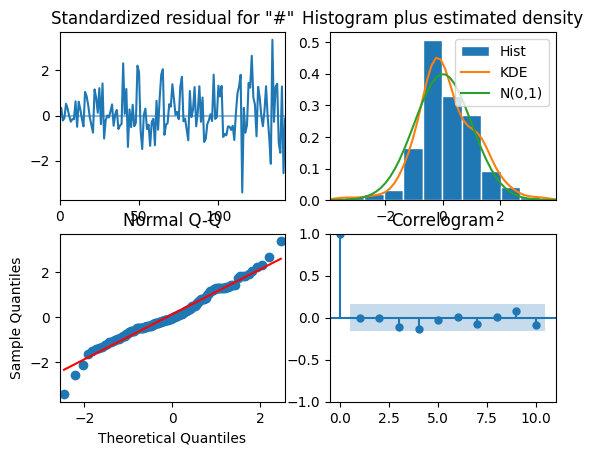

In [12]:
#fit the model with the best parameters found in our grid
arima = ARIMA(endog=df["#Passengers"].dropna(), order=(best_p, 1, best_q))
model = arima.fit()

#diagnose the model 

model.plot_diagnostics()
model.aic

#our residuals grow indicating a SARIMA model or an ARIMA model with optimized paramters may be a better option
#our histogram is fairly normally distributed but is slightly negatively skewed 
#95% of our lags with our residuals are not significant. This is a fairly good model but could be improved with SARIMA

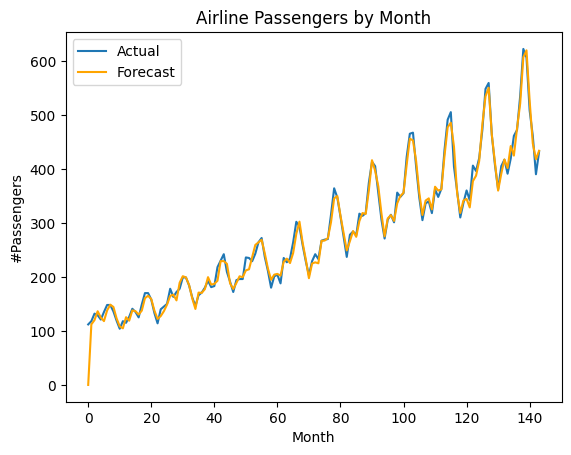

In [19]:
#check to see how are forecast algins with the dataset used to train. There should be a near match 
predictions = model.predict()

plt.plot(df.index, df["#Passengers"])
plt.plot(df.index, predictions, color="orange")

plt.xlabel("Month")
plt.ylabel("#Passengers")
plt.legend(["Actual", "Forecast", "Forecast_Future"])
plt.title("Airline Passengers by Month")
plt.draw()
plt.show()

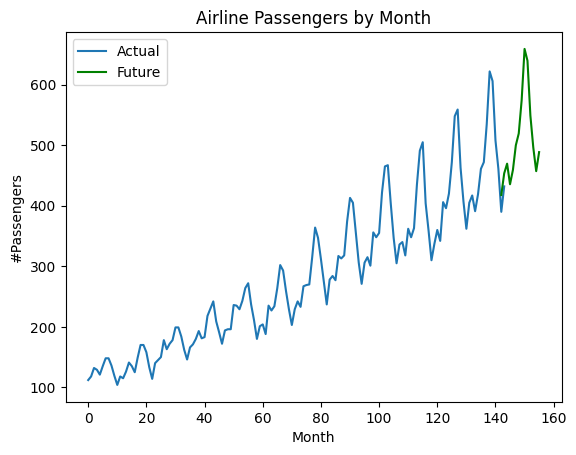

       Month #Passengers  first_diff  second_diff    forecast
142  1960-11         390       -71.0        -24.0  417.766621
143  1960-12         432        42.0        113.0  453.546161
144      NaN         NaN         NaN          NaN  469.536828
145      NaN         NaN         NaN          NaN  435.518993
146      NaN         NaN         NaN          NaN  459.207015
147      NaN         NaN         NaN          NaN  499.940396
148      NaN         NaN         NaN          NaN  519.375550
149      NaN         NaN         NaN          NaN  574.326504
150      NaN         NaN         NaN          NaN  659.121960
151      NaN         NaN         NaN          NaN  639.684467
152      NaN         NaN         NaN          NaN  549.134755
153      NaN         NaN         NaN          NaN  496.206750
154      NaN         NaN         NaN          NaN  457.189072
155      NaN         NaN         NaN          NaN  488.667241 forecast


In [28]:
#forecast future values 
future_indexes = [len(df.index) + x for x in range (0,12)]

future_predictions = pd.DataFrame(index=future_indexes, columns = df.columns)

df = pd.concat([df, future_predictions])

df["forecast"] = model.predict(start = 142, end = 155, dynamic=True)

plt.plot(df.index, df["#Passengers"])
plt.plot(df.forecast, color="green")

plt.xlabel("Month")
plt.ylabel("#Passengers")
plt.legend(["Actual", "Future"])
plt.title("Airline Passengers by Month")
plt.draw()
plt.show()

print(df.loc[142:155], "forecast")

#our final forecasts and their values using the model we created are found below 